# Prerequisites
- [Stocastics](Stochastics.ipynb)
- [Normal Distribution](../Probability/Normal%20Distribution/Normal%20Distribution.ipynb)

## Covariance is important
its a contraint that keeps like terms together
https://ekamperi.github.io/mathematics/2021/03/30/gaussian-process-regression.html

Matrix being positive definite This is the multivariate analog of the univariate requirement for the variance σ2 to be positive. 
https://ekamperi.github.io/mathematics/2021/03/30/gaussian-process-regression.html

## Kernels For A Gaussian Process

**Note:** Kernels appear in a number of mathematical fields and is often presented in an applied context with a more specific definition. They are used in image processing, interpolation, machine learning, and more. For a primer consider the following texts 
- https://www.cs.princeton.edu/~bee/courses/scribe/lec_10_09_2013.pdf
- [The kernel Cookbook](https://www.cs.toronto.edu/~duvenaud/cookbook/)

In [ ]:
import numpy
import scipy
from scipy.stats import multivariate_normal
from matplotlib import pyplot

# Generate a random normal variable which we will use to calculate probabilities
mu = [0, 0]
sigma = numpy.array([[1, 0.8],[0.8,2]])
rv = multivariate_normal(mu, sigma)

# Generate a number line
x = numpy.linspace(-7, 7, 200)

# Generate probabilities for the first random variable
normal_uv_rv = scipy.stats.norm(loc=0, scale=2)
p1 = normal_uv_rv.pdf(x)
x_1 = 1
p_x_1 = normal_uv_rv.pdf(x_1)

# Generate joint probabilities with a fixed X_1
x2 = x.copy()
grid_coord = numpy.column_stack((numpy.full(x2.shape, 1), x2))
p_x2_and_x1 = rv.pdf(grid_coord)

# Generate conditional probabilities given a fixed X_1
p_x2_given_x1 = p_x2_and_x1 / p1

# Calculate the means of the distributions
i = numpy.argmax(p1)
p1_mean_x = x[i]
p1_mean = p1[i]
i = numpy.argmax(p_x2_and_x1)
p_x2_and_x1_mean_x = x[i]
p_x2_and_x1_mean = p_x2_and_x1[i]
i = numpy.argmax(p_x2_given_x1)
p_x2_given_x1_mean_x = x[i]
p_x2_given_x1_mean = p_x2_given_x1[i]

# Plot
fig, ax = pyplot.subplots()
fig.set_figwidth(6)
fig.set_figheight(6)
ax.plot(x, p1, c='black')
ax.plot(x, p_x2_and_x1, c='blue')
ax.plot(x, p_x2_given_x1, c='green')
ax.scatter(p1_mean_x, p1_mean, c='black')
ax.scatter(p_x2_and_x1_mean_x, p_x2_and_x1_mean, c='blue')
ax.scatter(p_x2_given_x1_mean_x, p_x2_given_x1_mean, c='green')
ax.legend([
    "p($X_1)$", 
    "$p(X_2 \cap X_1=1)$", 
    "$p(X_2|X_1=1)$",
    "$\mu$ = {0}".format(p1_mean_x),
    "$\mu$ = {0}".format(p_x2_and_x1_mean_x),
    "$\mu$ = {0}".format(p_x2_given_x1_mean_x)
]);

### Gaussian (Squared Exponential)

$$ K(x, y) : \alpha^2 exp \left( {-\frac{(x - y)^2}{2\rho^2}} \right) + \sigma^2 \delta_{x, y} $$

The parameters are defined as follows:

- $\alpha$ - a hyper parameter which controls how likely the kernel returns a value near zero
- $\rho$
- $\sigma$
- $\delta$ - takes a value from 0 to 1 depending on whether or not 


In the diagram above, we can see the the effects on the distributions as we fix a variable. We see that the distributions move to the right by looking at the means (visually indicated by the peaks) and we see that the distributions narrow by looking at the variance (visually indicated by the widths). The green distribution shows us the unconditional probability of $X_1$. This distribution will also describe the unconditional probability of $X_2$. We see this distribution of $X_2$ changes as we fix a value of $X_1=1$. 

Looking at the black distribution, we see that the probability of obtaining any value of $X_2$ and obtaining a value $X_1=1$ is generally smaller than obtaining the same value of $X_2$ independently. This intuitively makes sense as there is a smaller chance that two things happen at the same time. Intuitively this makes sense: we are multiplying a small number (smaller than one) by another small number... so we will get an even smaller number. We also see that the mean of the distribution has moved to the right. This indicates that the value $X_2$ is likely to take is somewhere around 1 rather than 0. Additionally we see that the variance of the distribution shrinks which indicates that the range of values that the variable is likely to take on is also shrinking (definition of variance).

Finally, with the green distribution, we see that the $X_2$ is most likely to take on a value of 1.23 given that $X_1=1$.

We can look at the different shapes that the distribution will take on as the parameters change.

In [ ]:
import numpy
import itertools
from scipy.stats import multivariate_normal
from matplotlib import pyplot

def gaussian_kernel(diff, a, p, s, d):
    
    return a**2 * numpy.exp(-(diff)**2/2*p**2) + s**2 * d

def plot_variable(ax, diff, a, p, s, d):
    
    # Calculate the kernel values
    g = gaussian_kernel(diff, a, p, s, d)

# Generate a number line
diff = numpy.linspace(-5, 5, 200)

# Generate potting objects
fig, ax = pyplot.subplots(2,2)
ax = [ax[0][0],ax[0][1], ax[1][0], ax[1][1]]
fig.set_figwidth(12)
fig.set_figheight(12)
#ax.set_xlabel('x - y')
#ax.set_ylabel('K(x, y)')

params = ['a', 'p', 's', 'd']
possible_values = {
    'a': [-1, -.5, 0.1, .5, 1, 2, 5],
    's': [-1, -.5, 0.1, .5, 1, 2, 5],
    'p': [-1, -.5, 0.1, .5, 1, 2, 5],
    'd': [0, 1]
}
defaults = {
    'a': 1,
    's': 1,
    'p': 1/2,
    'd': 1
}
    
for i in range(0, len(params)):

    varied_param = params[i]
    
    # Set the defaults
    for j in range(0, len(params)):
        param_name = params[j]
        param_default = defaults[param_name]
        exec("{0} = {1}".format(param_name, param_default))
            
    legend_labels = []
    for value in possible_values[varied_param]:

        # Set the value of the variable that will be varried
        exec("{0} = {1}".format(varied_param, value))
                
        # Calculate the kernel values
        g = gaussian_kernel(diff, a, p, s, d)

        # Get the axis
        ax[i].plot(diff, g)
        
        legend_labels.append("a={0}, p={1}, s={2}, d={3}".format(a, p, s, d))
        
        ax[i].set_title(varied_param)
        
    ax[i].legend(legend_labels);

In [ ]:
        
        # plot
        if line_count < 10:
            ax.plot(diff, g)
        elif line_count < 20:
            ax.plot(diff, g, '--')
        elif line_count < 30:
            ax.plot(diff, g, '.')
        else:
            ax.plot(diff, g)

    legend_labels.append("a={0}, p={1}, s={2}, d={3}".format(a, p, s, d))
    
    line_count += 1
    
ax.legend(legend_labels);

In [ ]:
def gaussian_kernel(diff, a, p, s, d):
    
    return a**2 * numpy.exp(-(diff)**2/2*p**2) + s**2 * d


import numpy
import itertools
from scipy.stats import multivariate_normal
from matplotlib import pyplot

# Generate a number line
diff = numpy.linspace(-5, 5, 200)

# Generate potting objects
fig, ax = pyplot.subplots()
fig.set_figwidth(12)
fig.set_figheight(12)
ax.set_xlabel('x - y')
ax.set_ylabel('K(x, y)')

# Set the hyperparameters
possible_parameter_values = [0.1, 0.5, 1, 1.5, 2, 3]
permutations = itertools.combinations_with_replacement(possible_parameter_values, r=4)

legend_labels = []
line_count = 0
for permutation in permutations:
    
    a, p, s, d = permutation
    
    # Calculate the kernel values
    g = gaussian_kernel(diff, a, p, s, d)
    
    # Ignore those which do not behave like a probability distribution
    if g[numpy.argmax(g)] > 1:
        continue

    # plot
    if line_count < 10:
        ax.plot(diff, g)
    elif line_count < 20:
        ax.plot(diff, g, '--')
    elif line_count < 30:
        ax.plot(diff, g, '.')

    legend_labels.append("a={0}, p={1}, s={2}, d={3}".format(a, p, s, d))
    
    line_count += 1
    
ax.legend(legend_labels);

In [ ]:
line_count

# Kernels and Covariance

The covariance is such that the value returned is large if the values of the random variables are close to each other and small if they are not. It is defined mathematically as:

$$ Cov(X, Y) = E \left[(X - \mu_X)(Y-\mu_y) \right] $$
$$ = E[XY] - \mu_X \mu_Y $$

It is often derived as

$$ = \frac{\sum (X - \mu_X)(Y-\mu_y)}{n} $$

Knowing these are gaussian processes we assert $\mu=0$ which implies

$$ = \frac{\sum XY}{n} $$

For a single point, where $n=1$ we can further reduce the equation to

$$ = XY $$

We can think of the covariance matrix as a function which accepts a set of independent variables and returns their covariance:

$$ \Sigma = f(x, y) $$


We can see that this function satisfies the properties of a kernel function and thus we can say the covariance function is a kernel function

$$ \Sigma = K(x, y) $$

**Note:** Like the model of Brownian motion, Gaussian processes are stochastic processes. In fact, the Brownian motion process can be reformulated as a Gaussian process.

https://peterroelants.github.io/posts/gaussian-process-tutorial/

** Note sure why: "The gaussian proccess assumes that values within a search space will be most similar bewteen neighboring points. We will see this assumption is enforced as part of the mathematical framework."

-> see covariance commets about kernels

Assume we have a variable or function which depends on a set of parameters:

$$ y = f(X) $$

Assume variable or function is being modeled is a gaussian process:

$$ \hat y \sim \mathcal{N}(\mu, \Sigma) $$

# Gaussian Process Regression

## Overview

Gussian process regression is a technique which calibrates a [gussian process](../Stochastics/Stochastics.ipynb#Gaussian-Process) so that it models a set of observations. The intent is that once calibrated appropriately, the model can be used to make predictions. This technique goes by a few names including krigging and Wiener–Kolmogorov prediction.

Unlike many popular supervised machine learning algorithms that learn exact values for every parameter in a function, the Bayesian approach infers a probability distribution over all possible values.

Additionally, it is non-parametric and based on bayesian probability/inference.

The model is flexible as we do not neet to specify the underlying process and can model almost any function.

## History and Origin
The theoretical basis for the method was developed by the French mathematician Georges Matheron in 1960
His work was based on the Master's thesis of Danie G. Krige who sought to estimate the most likely distribution of gold based on samples from a few boreholes. The term kriging was coined some time after in honor of Krige.
https://en.wikipedia.org/wiki/Kriging

## Technique Overview


As the name suggests which is an analog of simple linear regression. Instead of fitting a line to our data (and thus predicting a specific value for a specific point) we are fitting a gaussian process to our data (and thus predicting a distribution for a specific point).

<center><img src='images/gaussian_process_distribution_prediction.png' width='400px'></center>

Note: Image compliments of this [lecture](https://www.youtube.com/watch?v=exqpaqaPG2Mhttps://www.youtube.com/watch?v=exqpaqaPG2Mhttps://www.youtube.com/watch?v=exqpaqaPG2Mhttps://www.youtube.com/watch?v=exqpaqaPG2M).

The technique starts by asserting that a function $f(x)$ or variable $y$ can be modeled by a gaussian process:

$$ y := f(x) \approx \mathcal{G}_i$$

In other words, for each value $x_i \in x$ we will construct a probability dsitrubtion $\mathcal{N}_i$ to explain the possible values that $y_i$ may take on. Additionally we state that there is some relationships between these distributions and thus the points. This relationship over some index is what makes this a process. And because of the specific distribution, the process can be modled by the multivariate normal distribution.

More specifically, for each point, we  get a prediction $\mu_i = \hat f_i$ but we also get a measure of uncertainy of the prediction in the form of $\sigma_i$.

$$ \mathcal{G}_i \sim \mathcal{N}_i $$

As we are modeling a non-trivial trend, the gaussian distribution parameters are expected to change over time which allows our process to change and exhibit trends.

$$ \mathcal{G}_i \sim \mathcal{N}(\mu_i, \Sigma_i)$$

We can think of a random process as a joint event such that the occurance of a process implies the occurance of a set of observations. As such we can model the probability of the process yielding the observed values as a joint probability. Because the process is gaussian, and thus the individual distributions are gaussian, we can actually derive concrete statements and formulas for this probability in the form of the multivariate gaussian distribution.

And this is where we start to see the opportunity to introduce bayesian inference into regression:

If we focus on a single prediction, we can effectively split our index into two segments. In segment one we have all the observed data points and in segment two we have all the data points we are trying to predict. Thus our segmented function can be represented as:

$$\begin{bmatrix}
f_1 \\ f_2
\end{bmatrix}
\sim
\mathcal{N}
\begin{pmatrix}
    \begin{bmatrix}
    \mu_1 \\
    \mu_2
    \end{bmatrix},
    \begin{bmatrix}
    \Sigma_{11} & \Sigma_{12} \\
    \Sigma_{21} & \Sigma_{22}
    \end{bmatrix}
\end{pmatrix}
$$

As we have formulated a joint probability distribution, we are stating that some relationship exists between these points. In fact, if we apply the theory of conditional probability, bayes theorem, and do the arduous matrix algebra we can derive a conditional probability distribution which stated the probabilities associated with $f_2$ given the occurance of $f_1$.

$$ f_2 | f_1 \sim \mathcal{N}(\mu_{f_2 | f_1}, \Sigma_{f_2 | f_1}) $$

With distribution moments:

$$ \mu_{f_2 | f_1} =  \mu_1 + \Sigma_{11}^{-1}\Sigma_{21}(x_2 - \mu_2)$$

$$ \Sigma_{f_2 | f_1} = S_{\Sigma/\Sigma_{11}} = \Sigma_{22} - \Sigma_{21}^{-1}\Sigma_{11}^{-1}\Sigma_{12}$$

**Note**: at this point we begin to leave the realm of exact science/mathematical riggor and we begin to enter the world of approximation. This was not called out explicitly in the materials I reviewed it and was extremely confusing for me as I tried to rigorously prove things which do not require riggor. We will see that we are going to make some statements and assumptions which are more artistic than scientific. But these assumptions are the heart of our model. They introduce an imperfect method to guess what the value of our prediction could/should be.

There are a few problems with the formulas above preventing them from being useful (which again is surprising as no one seems to acknowledge directly):
1. $f_2$ is unknown which implies that $\mu_2$, $\Sigma_{22}$, and $\Sigma_{22}$ are also unknown. This means we cannot compute the conditional mean or conditional covariance.
2. The standard covariance formula $Cov(x,y) = \frac{(x-\mu_x)(y-\mu_y)}{n-1}$ is not guaranteed to produce a positive definite matrix. In fact, I tried multiple examples and failed to generate a positive definite covariance matrix. As such we cannot take the inverse and compute the conditional covariance.


As such, we will see a lot of texts employ the following workarounds:
1. We will assume a value for $\mu_2$. To do this, we can either assume it is stationary and has a constant predetermined mean or that it is not stationary and we will compute a mean based on historical data.

2. We will assume/assert that $f$ is a smooth function. The reason for this is to establish that the covariance of $x$ can be used to approximate the covariance of $y$ on a relative basis. The basic idea is that a change in $x$ will be proportional to a change in $y$. In other words, if a point $x_i$ is close to a point $x_j$ then we will assume that a point $f_i$ is close to a point $f_j$. With this assumption, the covariance of $x$ will help us approximate values of $f$.

3. We will use alternate measurements to represent covariance which produce positive definite matrices more reliably. These functions are commonly referred to as **kernel functions** and will be discussed in their own section.


With these assumptions we now have a working mathematical system which can model our data. We will see that this model is versitile as we can make predictions for values coresponding to a domain we have not yet explored and we will be able to interpolate values between points in the domain we have explored.

Again, the heart of this model is thus the **kernel function** as it is really the major component that is artistically being selected.

Some additional notes:

1. There is a bit of a caveat when calculating $\Sigma_{11}^{-1}$. Numpy does offer a library to calculate the inverse, but there is a faster technique available for doing the calculation. We can calculate the $\Sigma_{11}^{-1}\Sigma_{21}$ term by solving a system of equations. We create an identity $Σ_{11} x = Σ_{12}$  which can be manipulated to $x = Σ_{12}/Σ_{11}$ or equivalently $Σ_{12}Σ_{11}^{-1}$. We will see this used in the coding examples below.

2.  I had some confusion early on because I was thinking about things in terms of a classical autoregression model. Meaning that I was thinking about the values of the prediction being tied to the time index. I was thinking that the order of the observations impacts the prediction. In other words I was thinking that when we make a prediction it is based on the previously observed values and their order. This is not the case with gaussian processes. We will see that a prediction for the value of a given point is based on the "similarity" of neighboring points (this is determined by the kernel function and discussed later). This is why we can both predict and interpolate. We will see examples of this below.

3. I have seen some texts try to draw a literal connection between gaussian process regression and linear regression. The premis is that the conditional mean is being used to represent the value of our prediction. Looking at its mathematical structure: $ \mu_{f_2 | f_1} =  \mu_1 + \Sigma_{11}^{-1}\Sigma_{21}(x_2 - \mu_2)$ we see that it can be considered a linear equation. 

   It is here that the connection with a regression is made. Recall that the generalized linear regression formula is such that:
   
   $$ f(x) = mX + b $$

   Looking at our conditional mean $\mu_{f_2 | f_1}$ we see that the formula resembles a linear regression. If we let $m = \Sigma_{11}^{-1}\Sigma_{21}$, $X=(x_2 - \mu_2)$, and $b=\mu_1$ we match exactly.

   Recalling that our model $\hat f(x)$ is an approximation and is subject to error $\epsilon$ we have:

   $$ \hat f(x) = f(x) + \epsilon $$

   While $\Sigma_{f_2 | f_1}$ measures the relative uncertainty in the prediction.

4. We previously suggested that we let $X=(x_2 - \mu_2)$ in our linear regression equation. In doing so, we are applying a normalizing transformation to $x_2$ such that X will have a mean of $0$ rather than $mu_2$. From the properties of a normal distribution we also know that linear transformations applied to a normal random variable is also normal. thus $X \sim \mathcal{N}(0, \sigma^2)$. Another interesting property of normal random variables is that an arbitrary normal distirbution $X$ can be represented as a transformation applied to a standard normal distirbution $\mathcal{Z}\sim\mathcal{N}(0,1)$ such that: $X = \mu_X + \sigma_X Z$. If you are not familiar with this equation, it is a brownian motion.

image 7 min in: https://www.youtube.com/watch?v=exqpaqaPG2Mhttps://www.youtube.com/watch?v=exqpaqaPG2M

Around 18 minutes: at each x we have a gausian. It is correlated with the previous. Series of correlated gaussians is multivariate gaussian

43 min in, construct a model to measure similiarity. Kernel does this -> plot kernel over domain so see curve?

44: we can modify the kernel to have the points be dissimilar

49: smoothness is such that a small variation in x means a small variation in y



is there connection with smoothness and stationarity??

data generating with covariance
https://bobby.gramacy.com/teaching/dataworks_rsm/lect2_doc.html

## Kernels and Kernel Functions
When talking about the Gaussian Process the term kernel or kernel function comes up a lot, especially as one becomes more advanced. This was confusing for me as the term kernel has a number of different definitions depending on the field of mathematics one finds themselves in. So it was hard to understand exactly what we were talking about.

Generally speaking, a [kernel function](../Functions/Functions.ipynb) is a symetric function which is usually positive. A kernel is a further generalization of the kernel function and can represent the domain of a function or a segment of an equation.

In the contect of gaussian process kernels and kenel functions mean something a little more specific. This is [not set in stone](https://stats.stackexchange.com/questions/228552/covariance-functions-or-kernels-what-exactly-are-they) but a kernel function yeilds a descriptive statistic explaining the relationship between the input variables.

The connection between kernels and the gaussian process is the covariance matrix/term that appears in the probability distribution function for the gaussian distribution. The $\Sigma$ term is a kernel function (despite not being positive definite).

There are other kernel functions which have the similar properties but different impacts on the distribution function. In some cases, data scientists may want to swap out one kernel function for another to provide a better fit/predicitve power to the model.

** Kernels help with smoothing
https://arxiv.org/pdf/2009.10862.pdf

### Choosing an alternate kernel

There are assumptions, pros, and cons baked into each kernel function.

Graph showing impact of different kernels

<center><img src='images/kernels_affecting_gaussian_process.png'  width='800px' height='800px' ></center>

https://ekamperi.github.io/mathematics/2021/03/30/gaussian-process-regression.html

http://www.cs.toronto.edu/~duvenaud/cookbook/index.html

## Limitations

- Slow inference. Computing the covariance matrix’s inverse has a O(N3) time complexity, rendering exact inference too slow for more than a few thousand data points.
- Choosing a covariance kernel. There’s some arbitrariness when choosing a kernel. However, the kernel’s hyperparameters can be inferred by maximizing the marginal likelihood, and the whole process can be automated.
- Gaussian processes are in some sense idealizations. For the understanding of extreme phenomena exhibited by real physical systems, non-Gaussian processes might turn out more suitable. In this context, GPs serve as starting points to be perturbed.

https://ekamperi.github.io/mathematics/2021/03/30/gaussian-process-regression.html

## Example 1

In this example we will iteratively make observations, update our understanding, make a prediction.

In [ ]:
# Enable interactive plot
# https://towardsdatascience.com/matplotlib-animations-in-jupyter-notebook-4422e4f0e389
# https://stackoverflow.com/questions/51922480/javascript-error-ipython-is-not-defined-in-jupyterlab
#%matplotlib widget
#%matplotlib notebook
%matplotlib widget

In [2]:
import numpy
import matplotlib.pyplot as pyplot
from matplotlib.animation import FuncAnimation

In [28]:
x = numpy.linspace(0, 2*numpy.pi, 100)

fig, ax = pyplot.subplots()
line, = ax.plot([])
ax.set_xlim(0, 2*numpy.pi)
ax.set_ylim(-1.1, 1.1)

def animate(frame_num):
    y = numpy.sin(x + 2*numpy.pi * frame_num/100)
    line.set_data((x, y))
    return line

anim = FuncAnimation(fig, animate, frames=100, interval=20)
pyplot.close() # Prevent the figure from displaying (dont want a static duplicate image)

from IPython.display import HTML
HTML(anim.to_jshtml())

TypeError: missing a required argument: 'y'

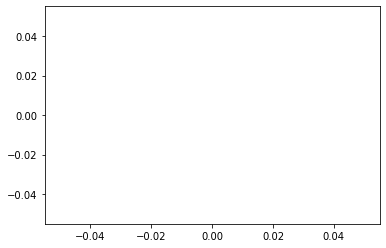

In [76]:
m = 5
b = 2
x = numpy.linspace(0, 5, 5)

fig, ax = pyplot.subplots()
line, = ax.plot([])
scatter, = ax.scatter([])
#ax.set_xlim(0, 2*numpy.pi)
#ax.set_ylim(-1.1, 1.1)

def animate(frame_num):
    frame_x = x[0: frame_num + 1]
    y = m * frame_x + b   
    #line.set_data((frame_x, y))
    scatter.set_data((frame_x, y))
    return line

anim = FuncAnimation(fig, animate, frames=x.size, interval=20)
#pyplot.close() # Prevent the figure from displaying (dont want a static duplicate image)

ax.set_ylim(-1, 10)


from IPython.display import HTML
HTML(anim.to_jshtml())

In [61]:
type(line)

matplotlib.lines.Line2D

# Examples

In the next few examples we look at using gaussian process regression to make predictions and perform interpolation.

## Prediction Examples

### Example 1: Zero-Mean Reverting

In this example we will create a sample set of data for a process which is mean reverting. We will then fit a gaussian process to the data and make a prediction for an unknown datapoint outside the bounds of those observed.

In [257]:
# Set parameters for the sample
sampe_size = 10
sample_domain = (-6, 6)

# Select evenly spaced datapoints along a number line and place them in a column vector
x1 = numpy.linspace(start=sample_domain[0], stop=sample_domain[1], num=sampe_size)
x1 = numpy.reshape(x1, (-1,1))

# Make observations for each of the selected datapoints
# Define the process as a sine wave with some random noise
e = numpy.random.normal(loc=0, scale=0.4, size=sampe_size).reshape(-1,1)
y1 = numpy.sin(x1) + e

# Generate the actual underlying function without the noise
f_x = numpy.linspace(start=sample_domain[0], stop=sample_domain[1] + 1, num=1000).reshape(-1, 1)
f_y = numpy.sin(f_x)

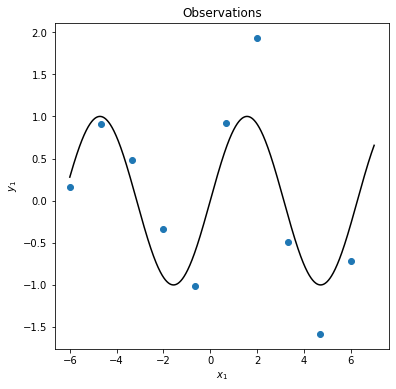

In [258]:
# Plot the observations against the actual underlying function
fig, ax = pyplot.subplots(nrows=1, ncols=1, figsize=(6, 6))
ax.plot(f_x, f_y, c='black')
ax.scatter(x1, y1)
ax.set_xlabel('$x_1$')
ax.set_ylabel('$y_1$')
ax.set_title('Observations')
pyplot.show();

Train and Test Model

We now generate a data point for an unknown datapoint outside the bounds of our observations.

In [259]:
# Let's look at a x-value that should return something close to 1
x2 = numpy.array([2 * numpy.pi]).reshape(-1, 1)

In [260]:
# Calculate the variance and covariance matrices required for the conditional moments
Σ11 = kernel(x1, x1)
Σ12 = kernel(x1, x2)
Σ22 = kernel(x2, x2)

In [261]:
Σ12_Σ11 = scipy.linalg.solve(Σ11, Σ12, assume_a='pos').T

In [262]:
# Calculate conditional parameters
μ1 = 0
μ2 = 0

μ_2_given_1 = μ2 + Σ12_Σ11 @ (y1 - μ1)
Σ_2_given_1 = Σ22 - (Σ12_Σ11 @ Σ12)

In [263]:
y2 = numpy.random.multivariate_normal(mean=μ_2_given_1.flatten(), cov=Σ_2_given_1, size=5)
y2

array([[-0.32549499],
       [-0.26390864],
       [-0.32222897],
       [ 0.11102714],
       [-0.9738465 ]])

In [265]:
# Compute the standard deviation at the test points to be plotted
σ2 = numpy.sqrt(numpy.diag(Σ_2_given_1))

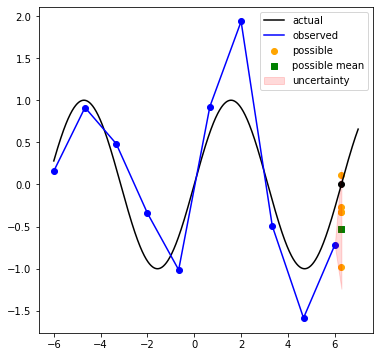

In [324]:
# Plot some samples from this function
fig, ax = pyplot.subplots(nrows=1, ncols=1, figsize=(6, 6))
ax.plot(f_x, f_y, c='black', label='actual')
ax.scatter(x1, y1, c='blue')
ax.plot(x1, y1, c='blue', label='observed')

ax.scatter(numpy.repeat(x2, y2.shape[0]), y2, c='orange', label='possible')
ax.scatter(x2, numpy.sin(x2), c='black')
ax.scatter(x2, μ_2_given_1, c='green', marker='s', label='possible mean')

tmp_x = numpy.array([x1[-1].reshape(-1, 1), x2]).astype('float64').flatten()
tmp_y_lower = numpy.array([y1[-1].reshape(-1, 1), μ_2_given_1 - 3*σ2]).astype('float64').flatten()
tmp_y_top = numpy.array([y1[-1].reshape(-1, 1), μ_2_given_1 + 3*σ2]).astype('float64').flatten()
ax.fill_between(tmp_x, tmp_y_lower, tmp_y_top, color='red', alpha=0.15, label='uncertainty')
ax.legend()
plt.show()


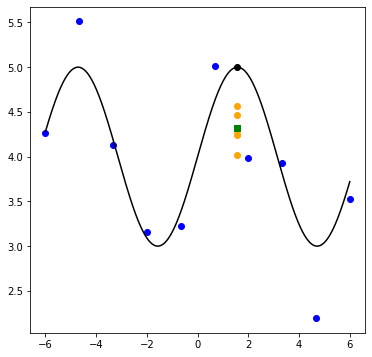

In [222]:
sampe_size = 10
sample_domain = (-6, 6)

x1 = numpy.linspace(start=sample_domain[0], stop=sample_domain[1], num=sampe_size)
x1 = numpy.reshape(x1, (-1,1))

e = numpy.random.normal(loc=0, scale=0.4, size=sampe_size)
e = numpy.reshape(e, (-1,1))

y1 = numpy.sin(x1) + 4 + e


f_x = numpy.linspace(start=sample_domain[0], stop=sample_domain[1], num=1000)
f_x = numpy.reshape(f_x, (-1,1))
f_y = numpy.sin(f_x) + 4

# Let's look at a x-value that should return something close to 1
x2 = numpy.array([numpy.pi / 2])
x2 = numpy.reshape(x2, (-1,1))

# Calculate the variance and covariance matrices required for the conditional moments
Σ11 = kernel(x1, x1)
Σ12 = kernel(x1, x2)
Σ22 = kernel(x2, x2)

Σ12_Σ11 = scipy.linalg.solve(Σ11, Σ12, assume_a='pos').T

# Calculate conditional parameters
μ1 = 0
μ2 = 0

μ_2_given_1 = μ2 + Σ12_Σ11 @ (y1 - μ1)
Σ_2_given_1 = Σ22 - (Σ12_Σ11 @ Σ12)

y2 = numpy.random.multivariate_normal(mean=μ_2_given_1.flatten(), cov=Σ_2_given_1, size=5)

# Plot some samples from this function
fig, ax = pyplot.subplots(nrows=1, ncols=1, figsize=(6, 6))
ax.plot(f_x, f_y, c='black')
ax.scatter(x1, y1, c='blue')
ax.scatter(x2, y2[0], c='orange')
ax.scatter(x2, y2[1], c='orange')
ax.scatter(x2, y2[2], c='orange')
ax.scatter(x2, y2[3], c='orange')
ax.scatter(x2, y2[4], c='orange')
ax.scatter(x2, numpy.sin(x2) + 4, c='black')
ax.scatter(x2, μ_2_given_1, c='green', marker='s')
plt.show()

## Example 3: Non-Stationary

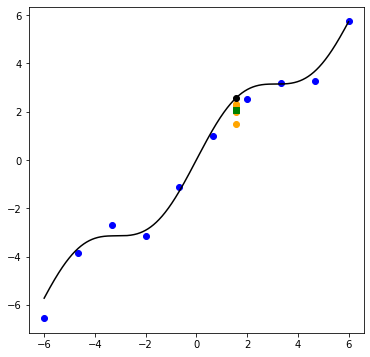

In [227]:
sampe_size = 10
sample_domain = (-6, 6)

x1 = numpy.linspace(start=sample_domain[0], stop=sample_domain[1], num=sampe_size)
x1 = numpy.reshape(x1, (-1,1))

e = numpy.random.normal(loc=0, scale=0.4, size=sampe_size)
e = numpy.reshape(e, (-1,1))

y1 = numpy.sin(x1) + x1 + e


f_x = numpy.linspace(start=sample_domain[0], stop=sample_domain[1], num=1000)
f_x = numpy.reshape(f_x, (-1,1))
f_y = numpy.sin(f_x) + f_x

# Let's look at a x-value that should return something close to 1
x2 = numpy.array([numpy.pi / 2])
x2 = numpy.reshape(x2, (-1,1))

# Calculate the variance and covariance matrices required for the conditional moments
Σ11 = kernel(x1, x1)
Σ12 = kernel(x1, x2)
Σ22 = kernel(x2, x2)

Σ12_Σ11 = scipy.linalg.solve(Σ11, Σ12, assume_a='pos').T

# Calculate conditional parameters
μ1 = 0
μ2 = 0

μ_2_given_1 = μ2 + Σ12_Σ11 @ (y1 - μ1)
Σ_2_given_1 = Σ22 - (Σ12_Σ11 @ Σ12)

y2 = numpy.random.multivariate_normal(mean=μ_2_given_1.flatten(), cov=Σ_2_given_1, size=5)

# Plot some samples from this function
fig, ax = pyplot.subplots(nrows=1, ncols=1, figsize=(6, 6))
ax.plot(f_x, f_y, c='black')
ax.scatter(x1, y1, c='blue')
ax.scatter(x2, y2[0], c='orange')
ax.scatter(x2, y2[1], c='orange')
ax.scatter(x2, y2[2], c='orange')
ax.scatter(x2, y2[3], c='orange')
ax.scatter(x2, y2[4], c='orange')
ax.scatter(x2, numpy.sin(x2) + x2, c='black')
ax.scatter(x2, μ_2_given_1, c='green', marker='s')
plt.show()

## Example 4: Interpolation

### Import libraries

In [228]:
# Import the necessary libraries
import numpy
import scipy
from scipy.spatial import distance
from matplotlib import pyplot as plt

### Generate Training Data
We will randomly select a set of points along the number line

In [229]:
# Create X values
train_n = 10
test_n = 80
stochastic_domain = (-6, 6)
x1 = numpy.random.uniform(stochastic_domain[0], stochastic_domain[1], size=(train_n, 1))

We then define an underlying process and calculate the values of the process for each of the points selected.

In [230]:
# Define the true function that we want to regress on
f_sin = lambda x: (numpy.sin(x)).flatten()

# Generate Y values
y1 = f_sin(x1)

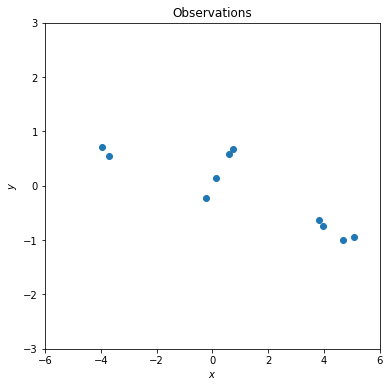

In [231]:
# Plot some samples from this function
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
ax.scatter(x1, y1)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_title('Observations')
ax.axis([stochastic_domain[0], stochastic_domain[1], -3, 3])
plt.show();

### Train model by choosing hyper parameters

In [232]:
def kernel(x1, x2):    
    return exponentiated_quadratic(x1, x2)

def exponentiated_quadratic(x1, x2):
    """Exponentiated quadratic  with σ=1"""
    # L2 distance (Squared Euclidian)
    sq_norm = -0.5 * scipy.spatial.distance.cdist(x1, x2, 'sqeuclidean')
    return numpy.exp(sq_norm)

In [233]:
x2 = numpy.linspace(stochastic_domain[0], stochastic_domain[1], test_n).reshape(-1, 1)

In [234]:
# Calculate the variance and covariance matrices required for the conditional moments
Σ11 = kernel(x1, x1)
Σ12 = kernel(x1, x2)
Σ22 = kernel(x2, x2)

In [235]:
x1

array([[-0.22331576],
       [-3.94536665],
       [ 0.61372241],
       [ 4.66671532],
       [-3.71745075],
       [ 3.81424743],
       [ 3.97381786],
       [ 0.141624  ],
       [ 5.06164258],
       [ 0.74775219]])

In [244]:
Σ12_Σ11 = scipy.linalg.solve(Σ11, Σ12, assume_a='pos').T

In [237]:
# Calculate conditional parameters
μ1 = 0            # Set the theoretical prior
μ2 = 0    # Calculate the observed statistic

μ_2_given_1 = μ2 + Σ12_Σ11 @ (y1.T - μ1)
Σ_2_given_1 = Σ22 - (Σ12_Σ11 @ Σ12)

In [243]:
# Simulate 5 processes
y2 = numpy.random.multivariate_normal(mean=μ_2_given_1, cov=Σ_2_given_1, size=5)

(80, 80)

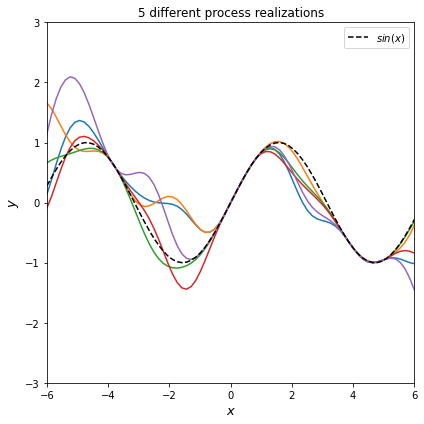

In [239]:

# Plot some samples from this function
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
ax.plot(x2, y2.T, '-')
ax.plot(x2, f_sin(x2), c='black', linestyle='--', label='$sin(x)$')
ax.set_xlabel('$x$', fontsize=13)
ax.set_ylabel('$y$', fontsize=13)
ax.set_title('5 different process realizations')
ax.axis([stochastic_domain[0], stochastic_domain[1], -3, 3])
ax.set_xlim([-6, 6])
ax.legend()
plt.tight_layout()
plt.show()

In [113]:
# Compute the standard deviation at the test points to be plotted
σ2 = numpy.sqrt(numpy.diag(Σ_2_given_1))

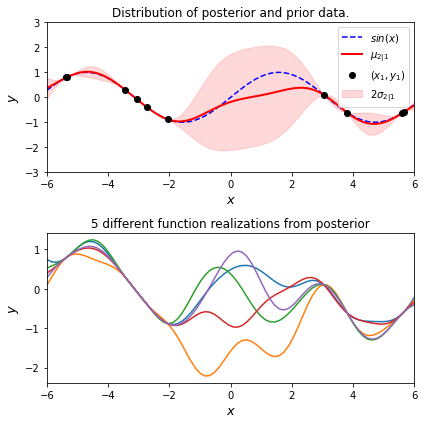

In [114]:
# Plot the postior distribution and some samples
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(6, 6))

# Plot the distribution of the function (mean, covariance)
ax1.plot(x2, f_sin(x2), 'b--', label='$sin(x)$')
ax1.fill_between(x2.flat, μ_2_given_1-2*σ2, μ_2_given_1+2*σ2, color='red', alpha=0.15, label='$2 \sigma_{2|1}$')
ax1.plot(x2, μ_2_given_1, 'r-', lw=2, label='$\mu_{2|1}$')
ax1.plot(x1, y1, 'ko', linewidth=2, label='$(x_1, y_1)$')
ax1.set_xlabel('$x$', fontsize=13)
ax1.set_ylabel('$y$', fontsize=13)
ax1.set_title('Distribution of posterior and prior data.')
ax1.axis([stochastic_domain[0], stochastic_domain[1], -3, 3])
ax1.legend()

# Plot some samples from this function
ax2.plot(x2, y2.T, '-')
ax2.set_xlabel('$x$', fontsize=13)
ax2.set_ylabel('$y$', fontsize=13)
ax2.set_title('5 different function realizations from posterior')
ax1.axis([stochastic_domain[0], stochastic_domain[1], -3, 3])
ax2.set_xlim([-6, 6])
plt.tight_layout()
plt.show()

# References
- https://www.ritchievink.com/blog/2019/02/01/an-intuitive-introduction-to-gaussian-processes/
- http://www.gaussianprocess.org/
- https://brendanhasz.github.io/2018/10/10/hmm-vs-gp.html
- https://distill.pub/2019/visual-exploration-gaussian-processes/
- https://online.stat.psu.edu/stat505/book/export/html/638
- https://peterroelants.github.io/posts/gaussian-process-tutorial/
- https://ekamperi.github.io/mathematics/2021/03/30/gaussian-process-regression.html

- https://arxiv.org/pdf/2009.10862.pdf
